In [4]:
library(dplyr)
library(ggplot2)
library(ggrepel)
library(data.table)
library(Seurat)
library(Signac)
library(pheatmap)
library(RColorBrewer)
library(Matrix)
library(fitdistrplus)
library(harmony)
source("/projects/ps-renlab2/y2xie/scripts/Paired-HiC/phc_help.R")
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Attaching SeuratObject

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: survival

Loading required package: Rcpp


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt




## Plot Higashi embedding (Fig.5B)


   0    1    2    3 
1053 1005  933  750 

[1] 3741

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


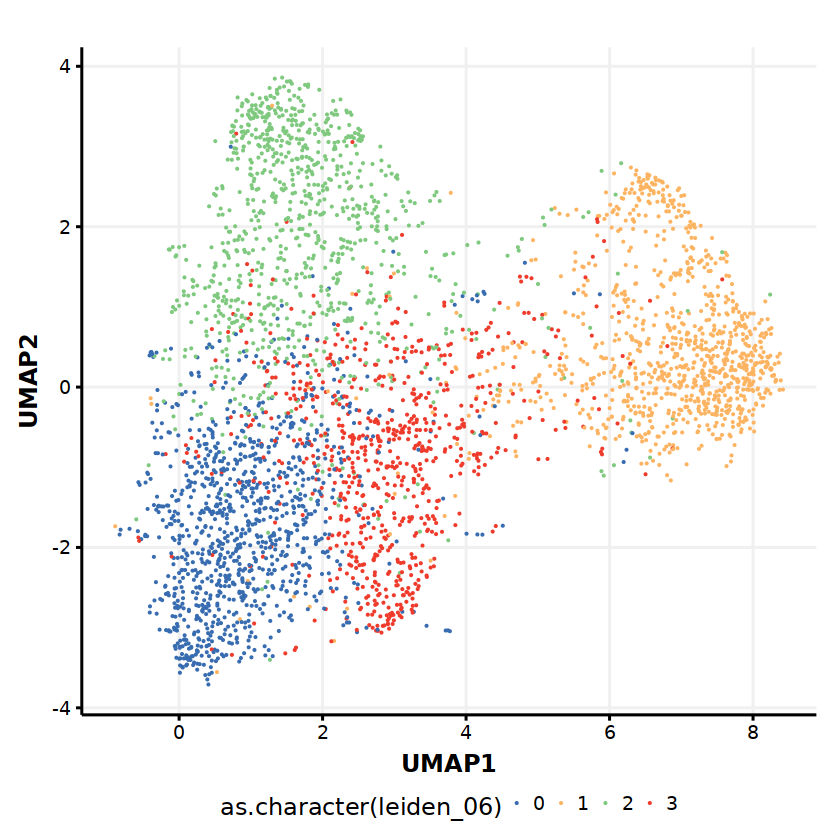

In [256]:
meta <- read.csv("LC675_scHiC_GBM_P4CC3_Higashi_leiden06.csv", header = T)
table(meta$leiden_06)

nrow(meta)

meta %>%
ggplot(aes(x = UMAP1, y = UMAP2)) + 
geom_point(aes(color = as.character(leiden_06)), size = 0.1) + 
theme_classic() + 
scale_colour_Publication() + 
theme_Publication()

## Plot ecDNA finding results (Fig.5F, J)

In [179]:
chrom_order <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/hg38.main.chrom.sizes")
chrom_order$V1

[1] "chr1"  "chr2"  "chr3"  "chr4"  "chr5"  "chr6"  "chr7"  "chr8"  "chr9" 
[10] "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17" "chr18"
[19] "chr19" "chr20" "chr21" "chr22" "chrX"  "chrY"

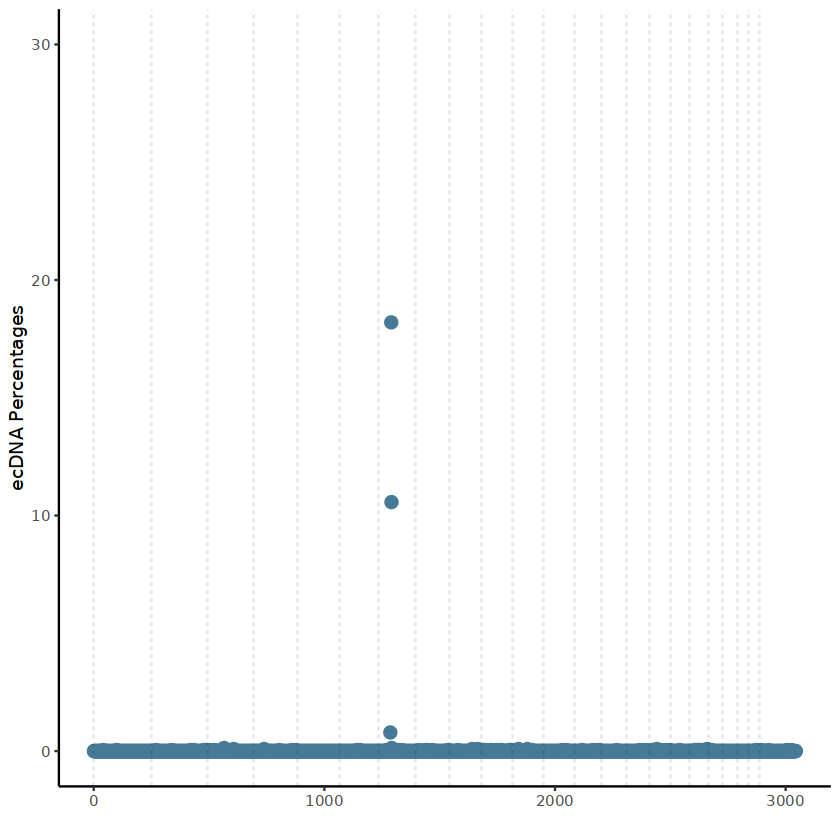

In [397]:
tmp <- read.table("../../38.scHiC_GBM/ecDNA_prediction_JC_results_231122/LC675_summary_ecDNA.txt", header = T)
tmp$chr <- factor(tmp$chr, levels = chrom_order$V1[1:23])
first_appear_indices = unlist(lapply(split(seq_len(nrow(tmp)), tmp$chr), function(x) x[1]))

t1 <- tmp %>%
tibble::rowid_to_column("id") %>%
ggplot(aes(x = id, y = 100*freq)) +
geom_point(color = colfunc2(6)[1], size = 3) + 
geom_vline(xintercept = first_appear_indices, linetype = "dashed", alpha = 0.1) +
theme_classic() + # scale_color_viridis() + 
xlab("") + ylim(c(0, 30)) + ylab("ecDNA Percentages")

t1
                                     
ggsave(t1, filename = "plot/102723_freq_LC676_LC677_ecDNA_prop.pdf", dpi = 300, height = 5, width = 8)

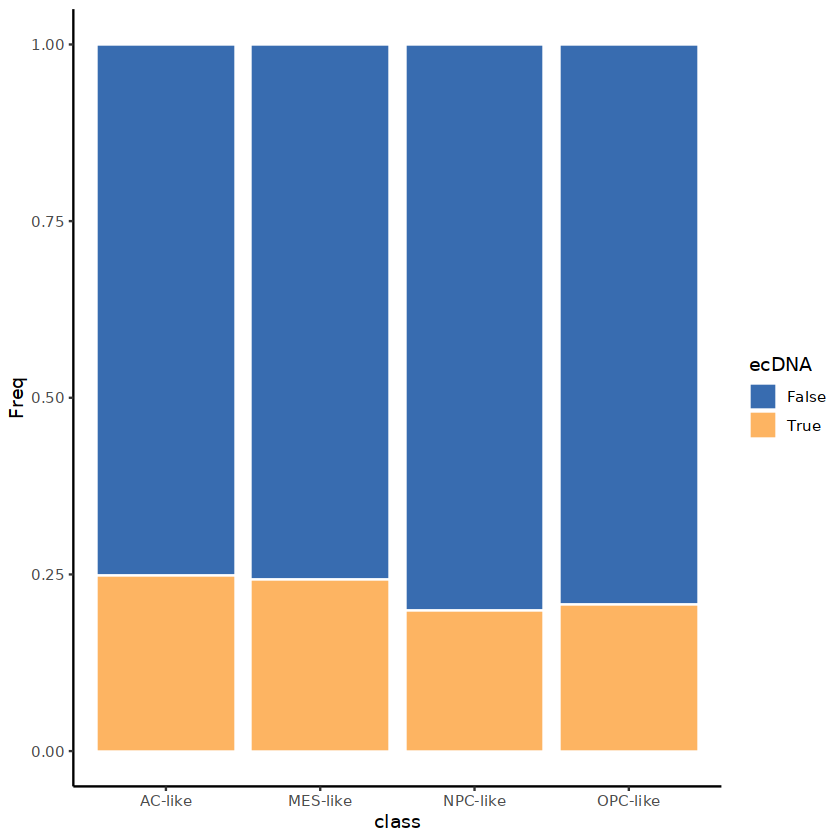

In [401]:
tmp <- read.table("../../38.scHiC_GBM/ecDNA_prediction_JC_results_231122/LC675_bin_barcode_matrix.txt", header = T)
ecDNA_cells <- colnames(tmp)[which(tmp[1290, ]+tmp[1291, ] > 0)]

### Paired with prediction: new
meta <- read.table("metadata/LC675_scHiC_GBM_P4CC3_RNA_prediction_231121_quadrant_cluster.info.txt", header = T, sep = "\t") 
valid <- intersect(substr(colnames(tmp), 7, 23), meta$barcode)
meta <- meta[meta$barcode %in% valid, ]

meta$ecDNA <- "False"
meta[meta$barcode %in% intersect(valid, substr(ecDNA_cells, 7, 23)), ]$ecDNA <- "True"

t1 <- merge(meta, score, by.x = "barcode", by.y = 0) %>%
select(c(ecDNA, class)) %>%
table %>% as.data.frame %>%
dplyr::filter(class %in% c("AC-like", "MES-like", "OPC-like", "NPC-like")) %>%
ggplot(aes(x = class, y = Freq, fill = ecDNA)) + 
geom_col(position = "fill", color = "white") + 
theme_classic() + scale_fill_Publication()

t1

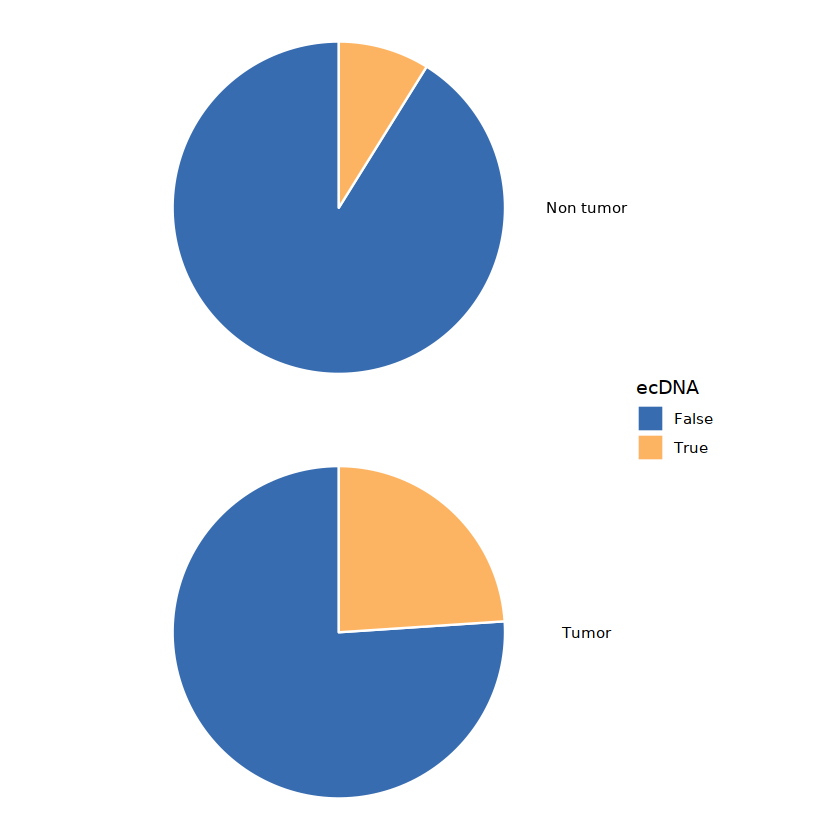

In [402]:
### Paired with prediction: new
meta <- read.table("metadata/LC675_scHiC_GBM_P4CC3_RNA_prediction_231121_quadrant_cluster.info.txt", header = T, sep = "\t") 
valid <- intersect(substr(colnames(tmp), 7, 23), meta$barcode)
meta <- meta[meta$barcode %in% valid, ]
meta <- meta %>% 
mutate(cluster = ifelse(cluster == "Non tumor", "Non tumor", "Tumor"))

meta$ecDNA <- "False"
meta[meta$barcode %in% intersect(valid, substr(ecDNA_cells, 7, 23)), ]$ecDNA <- "True"

t1 <- meta %>%
select(c(ecDNA, cluster)) %>%
table %>% as.data.frame %>%
ggplot(aes(x = "", y = Freq, fill = ecDNA)) + 
geom_col(position = "fill", color = "white") + 
coord_polar("y", start=0) + 
theme_void() + scale_fill_Publication() + 
facet_grid(cluster ~ .)

t1

ggsave(t1, filename = "plot/LC675_P4CC3_higashi_tumor_nonTumor_ecDNA_percentage_JC_231122.pdf", dpi = 300, height = 6, width = 6)
write.table(t1$data, "plot/LC675_P4CC3_higashi_tumor_nonTumor_ecDNA_percentage_JC_231122.txt", sep = "\t", quote = F)

## Plot CNV between tumor and non-tumor cells (Fig.5C-D,K)

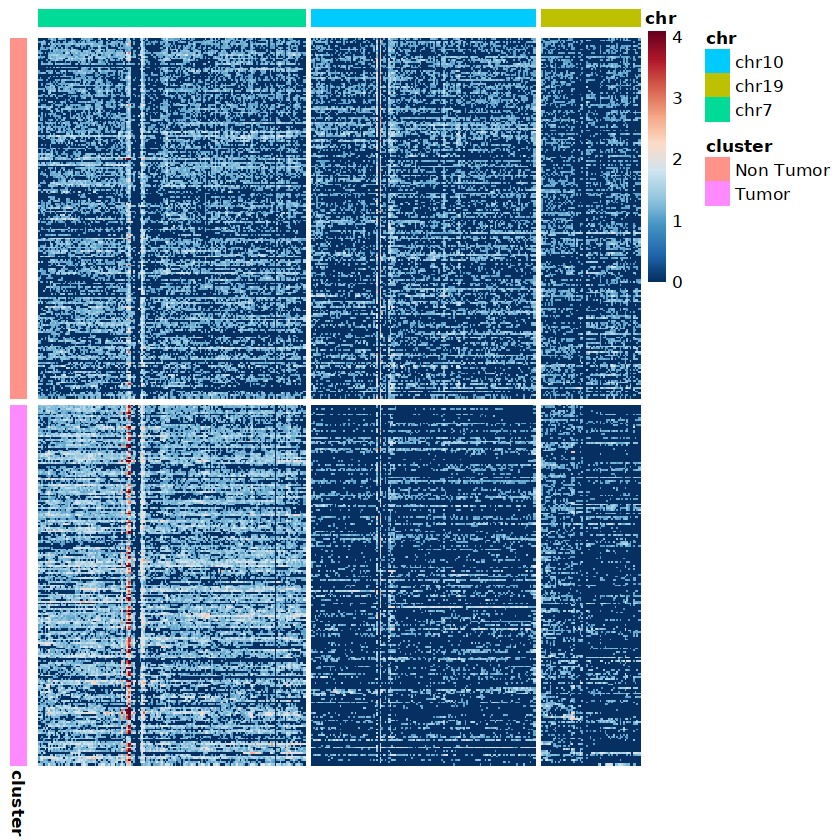

In [326]:
### Check copy number in top cells, tumor vs non tumor
cnv <- read.csv("LC675_all_cells_1000kb_cnv.xls", sep = "\t", row.names = 1) 
cnv[is.na(cnv)] <- 0
cnv[cnv > 16] <- 16

meta <- read.csv("../../64.schiC_MouseCortex_LC675/05.R/LC675_merged_scHiC_GBM_P4CC3_Higashi_leiden06.csv", header = T) %>%
mutate(cluster = ifelse(leiden_06 == 2, "Non Tumor", "Tumor"))
stat = read.table("../../64.schiC_MouseCortex_LC675/03.mapping/LC675_merged_hg38.PairCount.stat.csv")

meta$bc <- paste0("LC675_", meta$bc)
rownames(stat) <- paste0("LC675_", rownames(stat))
ctp <- intersect(meta$bc, rownames(cnv))

meta <- merge(stat, meta[meta$bc %in% ctp,], by.x = 0, by.y = "bc") %>%
group_by(cluster) %>% slice_max(order_by = total, n = 200) %>% ungroup() %>%
tibble::column_to_rownames("Row.names")

### focus on chr7 and chr10 and chr19 
tmp <- cnv[, grep(paste(c("chr7", "chr10", "chr19"), collapse = "|"), colnames(cnv))]
anno_col <- data.frame(names = colnames(tmp), chr = gsub("^([^_]+)_([^_]+)_([^_]+)$", "\\1", colnames(tmp))) %>%
tibble::column_to_rownames("names")

tmp[tmp < 1] <- 0

gap_row <- gap_col <- list()

for (f in anno_row$cluster){
    gap_row[[f]] <- which(anno_row$cluster == f)[1]
}

for (f in anno_col$chr){
    gap_col[[f]] <- which(anno_col$chr == f)[1]
}


t1 <- log2(tmp[rownames(anno_row),] + 1) %>%
pheatmap(border_color = NA, cluster_rows = F, cluster_cols = F, show_colnames = F,
         annotation_row = anno_row, annotation_col = anno_col, 
         gaps_row = unlist(gap_row) - 1, gaps_col = unlist(gap_col) - 1,
         show_rownames = F, color = colorRampPalette(rev(brewer.pal(n = 10, name = "RdBu")))(255))

ggsave(t1, filename = "plot//LC675_scHiC_GBM_P4CC3_tumor_nontumor_chr7_10_19_1Mb_copy_number_heatmap.pdf", 
       dpi = 300, height = 6, width = 12)

Using id, anno as id variables



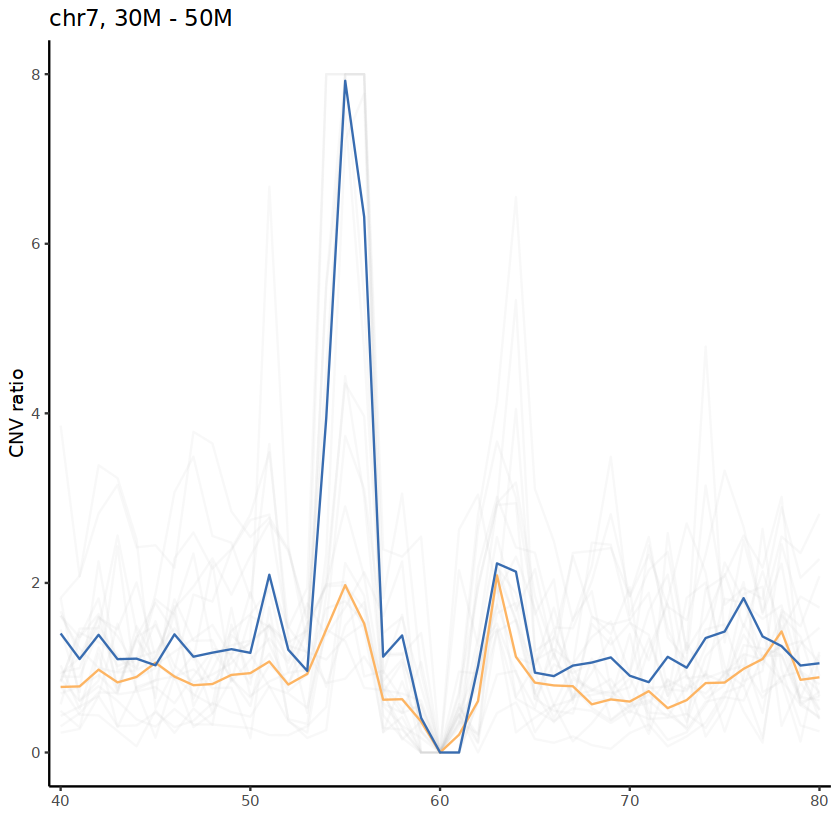

In [207]:
ttp_median <- ctp[rownames(anno_row2[anno_row2$rnatype2 == "Non tumor",,drop = F]), grep("chr7", colnames(ctp))] %>% 
apply(MARGIN = 2, median) %>% as.data.frame %>% setNames("value") %>% tibble::rowid_to_column("variable")
ttm_median <- ctp[rownames(anno_row2[anno_row2$rnatype2 == "Tumor",,drop = F]), grep("chr7", colnames(ctp))] %>% 
apply(MARGIN = 2, median) %>% as.data.frame %>% setNames("value") %>% tibble::rowid_to_column("variable")

ttp_median_m <- ttp_median %>% filter(variable %in% c(40:80)) %>% mutate(variable = as.character(variable))
ttm_median_m <- ttm_median %>% filter(variable %in% c(40:80)) %>% mutate(variable = as.character(variable))

tmp <- (ctp[rownames(anno_row2), grep("chr7", colnames(ctp))])
tmp$anno <- anno_row2$rnatype2

t1 <- tmp[c(1:10, 105:115),] %>% tibble::rownames_to_column("id") %>%
setNames(c("id", 1:(ncol(tmp) - 1), "anno")) %>%
reshape2::melt() %>%
dplyr::filter(variable %in% c(40:80)) %>%
ggplot(aes(x = variable, y = value)) + 
geom_line(aes(group = id), alpha = 0.1, color = "grey") + 
geom_line(data = ttp_median_m, 
          aes(x = variable, y = value, group = "."), color = "#fdb462") +
geom_line(data = ttm_median_m, 
          aes(x = variable, y = value, group = "."), color = "#386cb0") +
theme_classic() + xlab("") + ylab("CNV ratio") + ggtitle("chr7, 30M - 50M") + 
scale_x_discrete(breaks = as.character(seq(40, 80, 10)))

t1

ggsave(t1, filename = "LC675_scHiC_GBM_P4CC3_RNA_prediction_tumor_nontumor_chr7_cnv_summary.pdf", 
       dpi = 300, height = 6, width = 6)

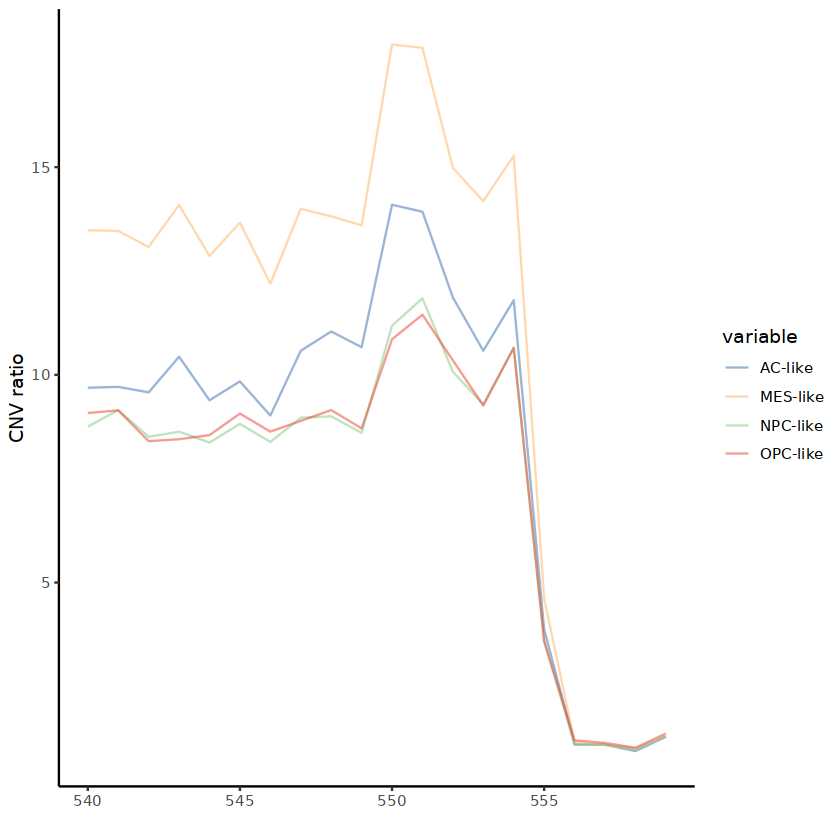

In [1279]:
### Let's do bulk 100kb: Fig.5K
cnv_list <- list()
for (f in c("AC-like", "MES-like", "NPC-like", "OPC-like")){
    tmp <- read.table(paste0("../04.matrices/merged/", f, "/", f, "/100000.CNV.bedGraph"))
    colnames(tmp) <- c("chrom", "start", "end", "residuals")
    tmp <- tmp[tmp$chrom == "chr7" & tmp$start >= 54000000 & tmp$end <= 56000000, ]
    colnames(tmp) <- c("chrom", "start", "end", f)
    rownames(tmp) <- paste0(tmp$chrom, "-", tmp$start, "-", tmp$end)
    cnv_list[[f]] <- tmp[, f, drop = F]
}

for (f in c("MES_AC-like", "OPC_NPC-like")){
    tmp <- read.table(paste0("../04.matrices/merged/two_states/", f, "/100000.CNV.bedGraph"))
    colnames(tmp) <- c("chrom", "start", "end", "residuals")
    tmp <- tmp[tmp$chrom == "chr7" & tmp$start >= 54000000 & tmp$end <= 56000000, ]
    colnames(tmp) <- c("chrom", "start", "end", f)
    rownames(tmp) <- paste0(tmp$chrom, "-", tmp$start, "-", tmp$end)
    cnv_list[[f]] <- tmp[, f, drop = F]
}

t1 <- do.call(cbind, cnv_list[1:4]) %>%
tibble::rowid_to_column("id") %>%
reshape2::melt(id.vars = "id") %>%
ggplot(aes(x = id + 539, y = value)) + 
geom_line(aes(group = variable, color = variable), alpha = 0.5) + 
theme_classic() + scale_colour_Publication() + xlab("") + ylab("CNV ratio")

t1

ggsave(t1, filename = "plot/LC675_GBM_states_bulk_CNV_chr7_540_560.pdf", dpi = 300, height = 6, width = 7)

## Gene fusion and gene expression (Fig.5G)

sparsity: 0.276344908609054
check readSums:  2 
check obj_mtx_collapse:  2 


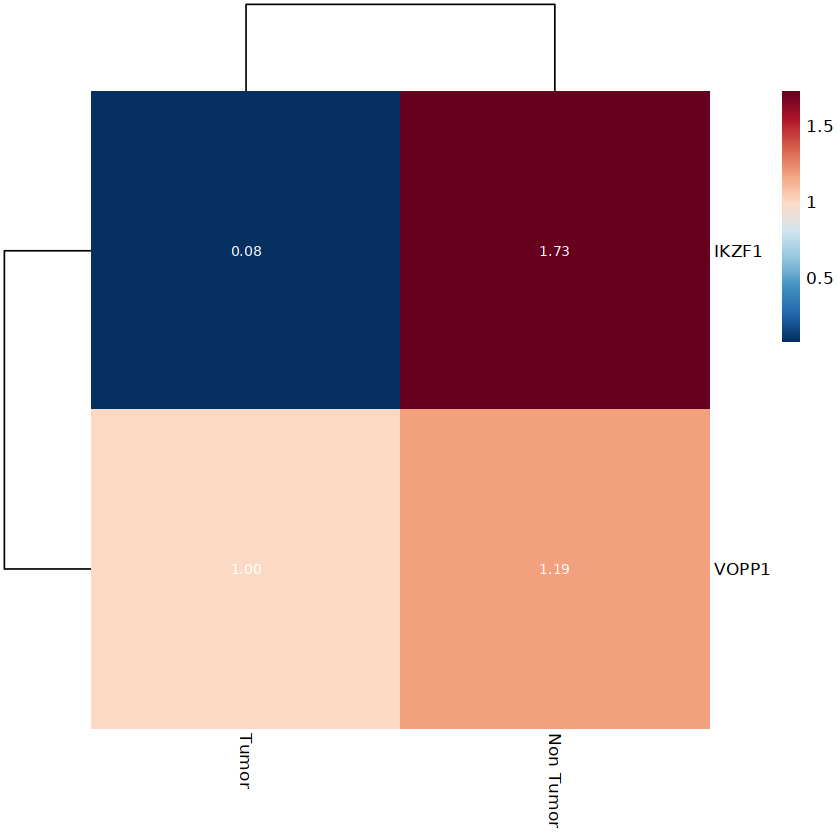

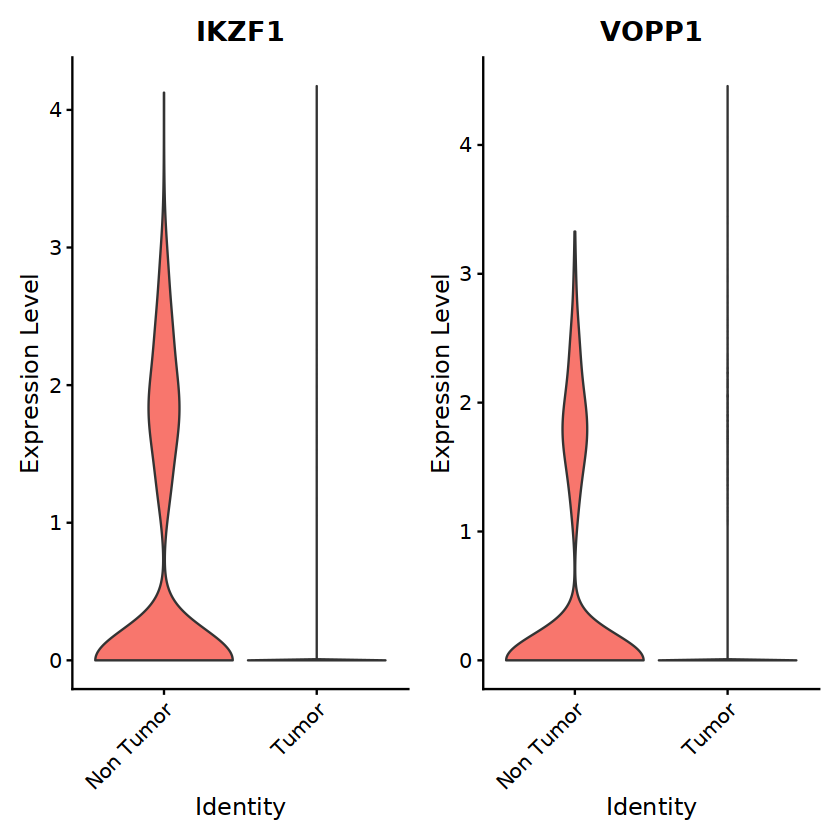

In [6]:
mmg$tumor <- "Tumor"
mmg@meta.data[mmg$state == "Non tumor", ]$tumor <- "Non Tumor"
cpm <- ArcXPM2(mmg[["RNA"]]@counts, method = "RPKM", mmg@meta.data, group.by = "tumor", 
               gene_length = "/projects/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.gcode.10X.bed")
t1 <- log2(cpm[c("IKZF1", "VOPP1"), ] + 1) %>%
pheatmap(scale = "none", border_color = NA, display_numbers = T, number_color = "white",
         color = colorRampPalette(rev(brewer.pal(n = 10, name = "RdBu")))(255))

VlnPlot(mmg, features = c("IKZF1", "VOPP1"), group.by = "tumor", pt.size = 0)

ggsave(t1, filename = "P4CC3_ZW_RNA_IKZF1_VOPP1_RPKM.pdf", dpi = 300, height = 6, width = 6)

## Identify GBM39 states using Butterfly plot (Fig.5H)

In [100]:
### Function for getScore and getQuadrant
### modified from https://github.com/jlaffy/scrabble/tree/master
source("/projects/ps-renlab2/y2xie/scripts/scrabble_score.R")
source("/projects/ps-renlab2/y2xie/scripts/scrabble_hierarchy.R")
source("/projects/ps-renlab2/y2xie/scripts/scrabble_bin.R")

In [102]:
### Load gene module
### gene module information from: https://pubmed.ncbi.nlm.nih.gov/31327527
module <- read.csv("../../public_data/GBM_GeneModule.csv")
gene_sets <- as.list(as.data.frame(module))

### Merge names
gene_sets[["MES"]] <- union(gene_sets[["MES1"]], gene_sets[["MES2"]]) %>% unique
gene_sets[["NPC"]] <- union(gene_sets[["NPC1"]], gene_sets[["NPC2"]]) %>% unique
gene_sets <- gene_sets[c("MES", "OPC", "NPC", "AC")]

for (cls in names(gene_sets)){
    gene_sets[[cls]] <- intersect(gene_sets[[cls]], rownames(mmg[["RNA"]]@counts))
}

### select only maglinant cells
tmp <- subset(mmg, subset = state != "Non tumor" & state != "Cell cycles") 
sc <- score(tmp[["RNA"]]@counts, groups = gene_sets, binmat = NULL, bins = NULL, 
                      controls = NULL, bin.control = F, center = T, nbin = 30, n = 100, replace = T) %>% 
as.data.frame(.)

h <- hierarchy(sc[,c("OPC", "NPC", "AC", "MES")], 
               quadrants = c("OPC", "NPC", "AC", "MES"), log.scale = T)
# c("bl", "br", "tl", "tr")
# Briefly, cells were first separated into
# OPC/-NPC-like vs. AC-/MES-like by the sign D = max(SCopc,SCnpc) - max(SCac,SCmes),
# and D defined the y-axis of all cells. Next, for OPC-/NPC-like cells, the x-axis value was
# defined as log2(|SCnpc – SCopc|+1) and for AC-like/MES-like cells (i.e., D < 0), the x-axis
# was defined as log2(|SCmes – SCac|+1). 

In [103]:
tmp <- merge(sc, h, by = 0) %>%
tibble::column_to_rownames("Row.names")

write.table(tmp, "P4CC3_ZW_Multiome_maglinant_butterfly_score.txt", sep = "\t", quote = F, row.names = T, col.names = T)

In [187]:
h <- read.table("P4CC3_ZW_Multiome_maglinant_butterfly_score.txt")
h$class <- NA
h[h$X > 0 & h$Y > 0, ]$class <- "MES-like"
h[h$X > 0 & h$Y < 0, ]$class <- "NPC-like"
h[h$X < 0 & h$Y > 0, ]$class <- "AC-like"
h[h$X < 0 & h$Y < 0, ]$class <- "OPC-like"

Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


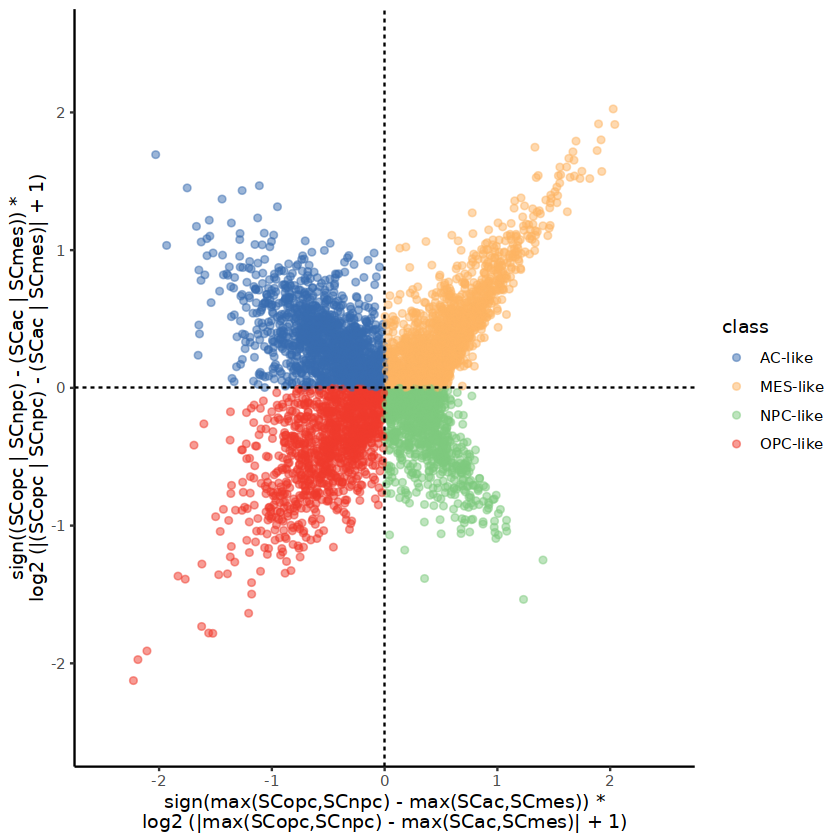

In [191]:
t1 <- h %>%
ggplot(aes(x = X, y = Y, color = class)) + 
geom_point(alpha = 0.5) + xlim(-2.5, 2.5) + ylim(-2.5, 2.5) +
geom_hline(yintercept = 0, color = "black", linetype="dashed") + 
geom_vline(xintercept = 0, color = "black", linetype="dashed") + 
theme_classic() + 
scale_colour_Publication() + 
xlab("sign(max(SCopc,SCnpc) - max(SCac,SCmes)) *\nlog2 (|max(SCopc,SCnpc) - max(SCac,SCmes)| + 1)") + 
ylab("sign((SCopc | SCnpc) - (SCac | SCmes)) *\nlog2 (|(SCopc | SCnpc) - (SCac | SCmes)| + 1)")

t1

ggsave(t1, filename = "P4CC3_RNA_cell_states_gene_score_butterfly.pdf", dpi = 300, height = 6, width = 7)

## Classify Hi-C states using butterfly score inferred from nearest neighbor (Fig.5I)

In [3]:
hic_score <- list()
for (ft in c("AC", "NPC", "OPC", "MES")){
    tmp <- read.table(paste0("GBM_states/LC675_maglinant_butterfly_score_", ft, "_euclidean_231130.txt"), sep = '\t', header = T, row.names = 1)
    hic_score[[ft]] <- apply(tmp, MARGIN = 1, function(x) median(as.numeric(unlist(x)), na.rm = T)) %>% as.data.frame
}

hic_score <- do.call(cbind, hic_score)
colnames(hic_score) <- c("AC", "NPC", "OPC", "MES")
hic_score <- na.omit(hic_score)                            
write.table(hic_score, "GBM_states/LC675_hic_maglinant_butterfly_score_euclidean.txt", 
            sep = "\t", quote = F, row.names = T, col.names = T)

Warning message:
“Removed 2 rows containing missing values (geom_point).”


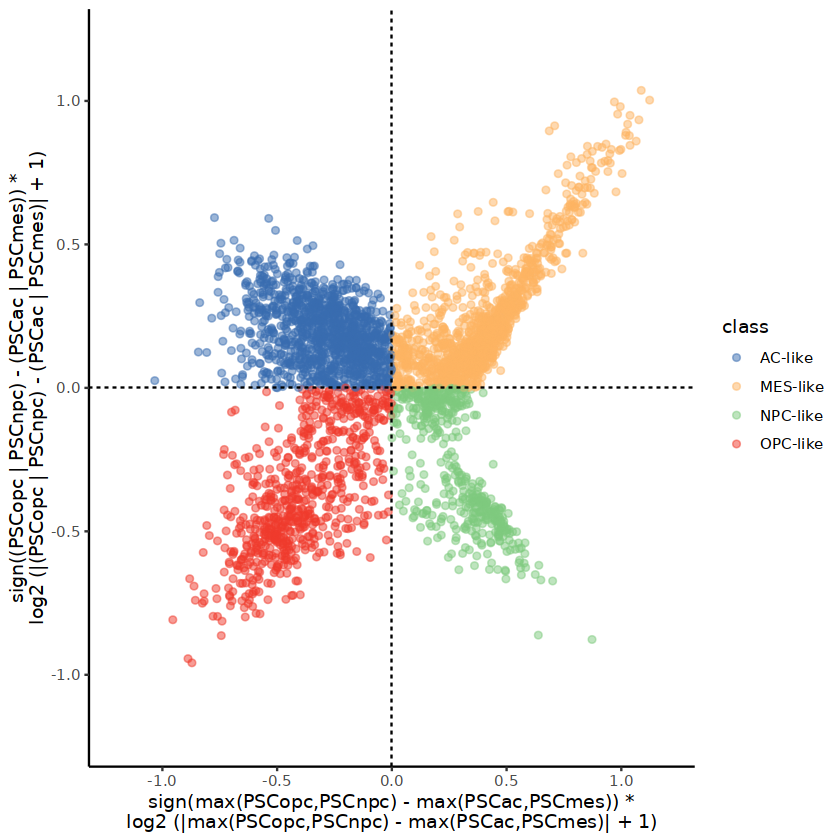

In [6]:
h <- hierarchy(hic_score[,c("OPC", "NPC", "AC", "MES")], 
               quadrants = c("OPC", "NPC", "AC", "MES"), log.scale = T)
h$class <- NA
h[h$X > 0 & h$Y > 0, ]$class <- "MES-like"
h[h$X > 0 & h$Y < 0, ]$class <- "NPC-like"
h[h$X < 0 & h$Y > 0, ]$class <- "AC-like"
h[h$X < 0 & h$Y < 0, ]$class <- "OPC-like"

score <- merge(hic_score, h, by = 0) %>%
tibble::column_to_rownames("Row.names")

t1 <- score %>%
ggplot(aes(x = X, y = Y, color = class)) + 
geom_point(alpha = 0.5) + xlim(-1.2, 1.2) + ylim(-1.2, 1.2) + 
geom_hline(yintercept = 0, color = "black", linetype = "dashed") + 
geom_vline(xintercept = 0, color = "black", linetype = "dashed") + 
theme_classic() + 
scale_colour_Publication() + 
xlab("sign(max(PSCopc,PSCnpc) - max(PSCac,PSCmes)) *\nlog2 (|max(PSCopc,PSCnpc) - max(PSCac,PSCmes)| + 1)") + 
ylab("sign((PSCopc | PSCnpc) - (PSCac | PSCmes)) *\nlog2 (|(PSCopc | PSCnpc) - (PSCac | PSCmes)| + 1)")

t1

ggsave(t1, filename = "plot/LC675_HiC_cell_states_gene_score_butterfly.pdf", 
       dpi = 300, height = 6, width = 7)

write.table(score, "GBM_states/LC675_hic_maglinant_butterfly_score_euclidean.txt", 
            sep = "\t", quote = F, row.names = T, col.names = T)

## Check ecDNA-associated gene expression (Fig.5O-P)

In [9]:
library(GenomicRanges)
hg38 <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.gcode.10X.bed")
hg38_genes.gr = GRanges(hg38[, 1], IRanges::IRanges(hg38[, 2], hg38[, 3]), gene = hg38[,6])
 
qry1 <- data.frame(chr = "chr7", start = 53640000, end = 55520000) ### range in GBM
qry1.gr = GRanges(qry1[, 1], IRanges::IRanges(qry1[, 2], qry1[, 3]))
qry1.gene <- hg38[unique(queryHits(findOverlaps(hg38_genes.gr, qry1.gr))), ]

qry1.gene <- intersect(rownames(mmg[["RNA"]]@counts), qry1.gene$V6)
qry1.gene
length(qry1.gene)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:Matrix’:

    expand, unname


The following objects are masked from ‘package:data.table’:

    first, second


The following objects are 

[1] "LINC01446"  "LINC02854"  "AC092848.2" "AC092848.1" "LINC01445" 
 [6] "VSTM2A"     "VSTM2A-OT1" "AC011228.1" "AC011228.2" "SEC61G"    
[11] "AC074351.1" "EGFR"       "EGFR-AS1"   "ELDR"       "LANCL2"    
[16] "VOPP1"

[1] 16

In [221]:
### Plot gene on butterfly plot
gex <- mmg[["RNA"]]@data[c("SEC61G", "EGFR", "LANCL2"), rownames(mmg@meta.data[!is.na(mmg$X), ])] %>% t %>% as.data.frame
gex <- merge(mmg@meta.data, gex, by = 0)

label <- data.frame(anno = c("AC-like", "MES-like", "OPC-like", "NPC-like"), 
                    xcod = c(-2.3, 2.3, -2.3, 2.3), ycod = c(2.3, 2.3, -2.3, -2.3))
plotl <- list()
for (f in c("SEC61G", "EGFR", "LANCL2")){
    plotl[[f]] <- gex %>% dplyr::select(c(X, Y, all_of(f))) %>% 
    setNames(c("X", "Y", "gene")) %>%
    ggplot(aes(x = X, y = Y)) + 
    geom_point(aes(color = gene), alpha = 0.5) + xlim(-2.5, 2.5) + ylim(-2.5, 2.5) +
    geom_text(data = label, aes(x = xcod, y = ycod, label = anno), size = 4) +
    geom_hline(yintercept = 0, color = "black", linetype="dashed") + 
    geom_vline(xintercept = 0, color = "black", linetype="dashed") + 
    theme_classic() + ggtitle(f) + 
    scale_colour_viridis_c() + 
    xlab("sign(max(SCopc,SCnpc) - max(SCac,SCmes)) *\nlog2 (|max(SCopc,SCnpc) - max(SCac,SCmes)| + 1)") + 
    ylab("sign((SCopc | SCnpc) - (SCac | SCmes)) *\nlog2 (|(SCopc | SCnpc) - (SCac | SCmes)| + 1)")
}
fig1 <- cowplot::plot_grid(plotlist = plotl, ncol = 3)
ggsave(fig1, filename = "P4CC3_ZW_Multiome_butterfly_score_ecDNA_gene_exp.pdf", dpi = 300, height = 3.5, width = 12)

Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


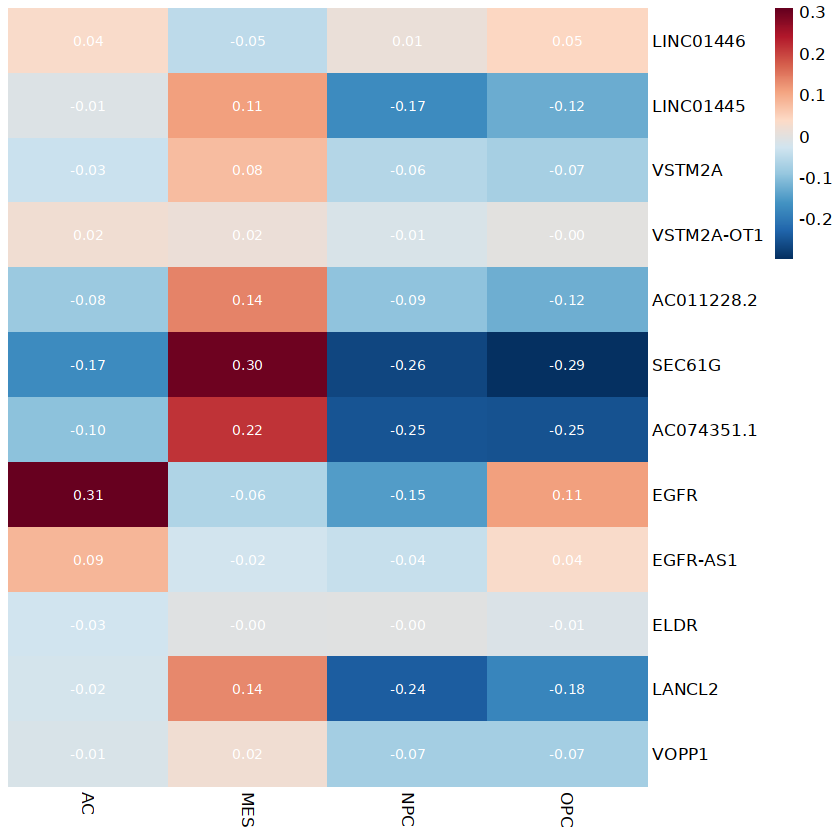

In [342]:
### associate gene with score: SCC
sc <- read.table("GBM_states/P4CC3_ZW_Multiome_maglinant_butterfly_score.txt")
mmg <- AddMetaData(mmg, sc, colnames(sc))
mmg_exp <- mmg[["RNA"]]@counts[qry1.gene,] %>% t %>% as.data.frame
tmp <- merge(mmg_exp, mmg@meta.data[,colnames(sc)], by = 0) %>%
tibble::column_to_rownames("Row.names") %>%
dplyr::filter(!is.na(X))

cor_list <- list()
for (gene in allow_gene){
    cor_tmp <- tmp %>% dplyr::select(c(gene, MES, OPC, NPC, AC)) %>% 
    cor(method = "spearman") %>% as.data.frame 
    cor_list[[gene]] <- cor_tmp[gene, c("AC", "MES", "NPC", "OPC")]
}
t1 <- do.call(rbind, cor_list) %>%
pheatmap(cluster_rows = F, cluster_cols = F, display_numbers = T, 
         border_color = NA, number_color = "white",
         color = colorRampPalette(rev(brewer.pal(n = 10, name = "RdBu")))(255))

ggsave(t1, filename = "P4CC3_ZW_Multiome_SCC_butterfly_score_ecDNA_GEX.pdf", dpi = 300, height = 7, width = 5)

## Plot EGFR gene expression / accessibility (Fig.5L-M)

In [ ]:
### Plot RNA gene expression at the same time?
mmg <- readRDS("P4CC3_ZW_Multiome_RNA.rds")
tt <- mmg[["RNA"]]@data["EGFR",] %>%
as.data.frame %>%
setNames("EGFR")

t1 <- cbind(mmg@meta.data, tt) %>%
dplyr::filter(abs(X) > 0.5 & abs(Y) > 0.5) %>%
ggplot(aes(x = quadrant_state, y = EGFR)) + 
geom_violin(aes(fill = quadrant_state), alpha = 0.5) + 
geom_boxplot(width = 0.1, color = "black", 
             alpha = 0.8, coef = 2, outlier.alpha = 0.5) +
# geom_jitter(color = "grey", alpha = 0.5) + 
xlab("") + ylab("EGFR Normalized Expression") + 
scale_fill_Publication() + 
theme_classic()

ggsave(t1, filename = "P4CC3_RNA_cell_states_EGFR_normalized_exp_cutoff05.pdf", 
       dpi = 300, height = 6, width = 7)

In [ ]:
### Also plot ATAC gene score
# mmg <- readRDS("P4CC3_ZW_Multiome_atac.rds")
meta <- merge(mmg@meta.data, t2$data[,c("quadrant_state", "X", "Y")], by = 0) %>%
tibble::column_to_rownames('Row.names') 

tt <- mmg[["RNA"]]@data["EGFR",] %>%
as.data.frame %>%
setNames("EGFR")

t1 <- merge(meta, tt, by = 0) %>%
dplyr::filter(abs(X) > 0.5 & abs(Y) > 0.5) %>%
ggplot(aes(x = quadrant_state, y = EGFR)) + 
geom_violin(aes(fill = quadrant_state), alpha = 0.5) + 
geom_boxplot(width = 0.1, color = "black", 
             alpha = 0.8, coef = 2, outlier.alpha = 0.5) +
# geom_jitter(color = "grey", alpha = 0.5) + 
xlab("") + ylab("EGFR Normalized ATAC Gene Score") + 
scale_fill_Publication() + 
theme_classic()

ggsave(t1, filename = "P4CC3_ATAC_cell_states_EGFR_normalized_ATAC_score_cutoff05.pdf", 
       dpi = 300, height = 6, width = 7)
